# Solution Planning

## Input

**Problema de negocio:**

Rossmann opera mais de 3.000 drogarias em 7 países europeus. Atualmente, os gerentes de loja da Rossmann têm a tarefa de prever suas vendas diárias com até seis semanas de antecedência. As vendas da loja são influenciadas por muitos fatores, incluindo promoções, competição, feriados escolares e estaduais, sazonalidade e localidade. Com milhares de gerentes individuais prevendo vendas com base em suas circunstâncias únicas, a precisão dos resultados pode ser bastante variada.

1. Prever vendas diaárias com 6 semanas de antecencias.
2. Quais fatores mais influenciam as vendas? (promoções, competição, feriados escolares e estaduais, sazonalidade e localidade)
3. base de  dados Rossmann

## Output

1. Modelo de Machine Learning para prever vendas das proximas 6 semanas por loja.
2. disponibilizar API com o modelo.
3. Graficos com os 5 principais fatores que influencias as vendas.

## Task

1. Modelo de Machine Learning para prever vendas das proximas 6 semanas por loja.

* 1.1. Descrição de Features
* 1.2. Feature Engeerring
* 1.3. Data Filtering
* 1.4. criação de hipoteses de negocio
* 1.5. EDA univariadas, bivariadas, multivariadas e validação/refutação das hipoteses de negocio
* 1.6. Data Preparation
* 1.7. Feature Selection
* 1.8. Trainig model, para selecionar o modelo que melhores modela o problema.
* 1.9. Traduzir a perfomance do modelo em performance de Negocio.


2. disponibilizar API com o modelo.
* 2.1. Criação de API dos arquivos para API.
* 2.2. Fazer deploy da API no heroku.

3. Graficos com os 5 principais fatores que influencias as vendas.

# 0.0. Imports

In [142]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from xgboost import XGBRegressor
from pandas_profiling import ProfileReport
from IPython.display import HTML
from IPython.display import Image

from sklearn import model_selection as ms
from sklearn.dummy import DummyRegressor
from sklearn import metrics
from sklearn import linear_model as lm
from sklearn import ensemble as en
from sklearn import preprocessing as pp

## 0.1. Helper Functions

In [143]:
def descriptive_statistics(num_attr):
    # Central Tendency: mean, median
    c1 = pd.DataFrame(num_attr.apply(np.mean))
    c2 = pd.DataFrame(num_attr.apply(np.median))

    # Dispension: min, max, range, std, skew, kurtosis
    d1 = pd.DataFrame(num_attr.apply(min))
    d2 = pd.DataFrame(num_attr.apply(max))
    d3 = pd.DataFrame(num_attr.apply(lambda x: x.max() - x.min()))
    d4 = pd.DataFrame(num_attr.apply(lambda x: x.std()))
    
    # Measures of Shape
    s1 = pd.DataFrame(num_attr.apply(lambda x: x.skew()))
    s2 = pd.DataFrame(num_attr.apply(lambda x: x.kurtosis()))

    # concat
    m = pd.concat([d1,d2,d3,c1,c2,d4,s1,s2], axis=1).reset_index()
    m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
    return m


def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list = []
    mape_list = []
    rmse_list = []
    
    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
        # start and end date for validation 
        validation_start_date = x_training['date'].max() - datetime.timedelta( days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta( days=(k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        # training
        xtraining = training.drop( ['date', 'sales'], axis=1 ) 
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']

        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m.predict( xvalidation )

        # performance
        m_result = ml_error( model_name, yvalidation ,  yhat  )

        # store performance of each kfold iteration
        mae_list.append(  m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )
        
        dict_ = {'Model Name': model_name,
                 'MAE CV': np.round( np.mean( mae_list ), 3 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 3 ).astype( str ),
                 'MAPE CV': np.round( np.mean( mape_list ), 3 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 3 ).astype( str ),
                 'RMSE CV': np.round( np.mean( rmse_list ), 3 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 3 ).astype( str ) }

    return pd.DataFrame( dict_, index=[0] )


def ml_error(model_name, y_test, yhat,):
    mae = metrics.mean_absolute_error(y_test, yhat)
    mape = metrics.mean_absolute_percentage_error(y_test, yhat)
    rmse = np.sqrt(metrics.mean_squared_error(y_test, yhat))
    
    dict_ = {'Model': model_name,
             'MAE': mae,
             'MAPE': mape,
             'RMSE': rmse
    }
    
    return pd.DataFrame(dict_, index=[0])


def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    pd.set_option('display.float_format', lambda x: '%.2f' % x)
    
    sns.set_style("whitegrid")
    
    sns.set()
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2. Load Data

In [144]:
df_store_raw = pd.read_csv('../data/store.csv', low_memory=False)
df_sales_raw = pd.read_csv('../data/train.csv', low_memory=False)

# merge
df_raw = pd.merge(df_store_raw, df_sales_raw, how='left', on='Store')

# 1.0. Data Description

In [145]:
df1 = df_raw.copy()

## 1.1. Rename Columns

* **Id** -  an Id that represents a (Store, Date) duple within the test set
* **Store** -  a unique Id for each store
* **Sales** -  the turnover for any given day (this is what you are predicting)
* **Customers** -  the number of customers on a given day
* **Open** -  an indicator for whether the store was open: 0 = closed, 1 = open
* **StateHoliday** -  indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
* **SchoolHoliday** -  indicates if the (Store, Date) was affected by the closure of public schools
* **StoreType** -  differentiates between 4 different store models: a, b, c, d
* **Assortment** -  describes an assortment level: a = basic, b = extra, c = extended
* **CompetitionDistance** -  distance in meters to the nearest competitor store
* **CompetitionOpenSince[Month/Year]** -  gives the approximate year and month of the time the nearest competitor was opened
* **Promo** -  indicates whether a store is running a promo on that day
* **Promo2** -  Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
* **Promo2Since[Year/Week]** -  describes the year and calendar week when the store started participating in Promo2
* **PromoInterval** -  describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [146]:
cols = ['store',
        'store_type',
        'assortment',
        'competition_distance',
        'competition_open_since_month',
        'competition_open_since_year',
        'promo2',
        'promo2_since_week',
        'promo2_since_year',
        'promo_interval',
        'day_of_week',
        'date',
        'sales',
        'customers',
        'open',
        'promo',
        'state_holiday',
        'school_holiday']

df1.columns = cols

## 1.2. Data Dimensions

In [147]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Cols: {}'.format(df1.shape[1]))

Number of Rows: 1017209
Number of Cols: 18


## 1.3. Data Types

In [148]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
dtype: object

## 1.4. Check NA

In [149]:
df1.isna().sum()

store                                0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
dtype: int64

## 1.5. Replace NA

In [150]:
# competition_distance
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if np.isnan(x) else x)

In [151]:
# competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if np.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

# competition_open_since_year
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if np.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

In [152]:
# promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if np.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

# promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if np.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

In [153]:
# promo_interval
month_map = {1: 'Jan',  2: 'Fev',  3: 'Mar',  4: 'Apr',  5: 'May',  6: 'Jun',  7: 'Jul',  8: 'Aug',  9: 'Sep',  10: 'Oct', 11: 'Nov', 12: 'Dec'}
df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )

In [154]:
df1.isna().sum()

store                           0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6. Change Dtypes

In [155]:
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## 1.7. Statistical Descriptive

In [156]:
num_attr = df1.select_dtypes(include=['int64', 'float64'])
cat_attr = df1.select_dtypes(include=['object'])

### 1.7.1. Numerical Attributes

In [157]:
descriptive_statistics(num_attr)

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.00,1115.00,1114.00,558.43,558.00,321.91,-0.00,-1.20
1,competition_distance,20.00,200000.00,199980.00,5935.44,2330.00,12547.65,10.24,147.79
2,competition_open_since_month,1.00,12.00,11.00,6.79,7.00,3.31,-0.04,-1.23
3,competition_open_since_year,1900.00,2015.00,115.00,2010.32,2012.00,5.52,-7.24,124.07
4,promo2,0.00,1.00,1.00,0.50,1.00,0.50,-0.00,-2.00
5,promo2_since_week,1.00,52.00,51.00,23.62,22.00,14.31,0.18,-1.18
6,promo2_since_year,2009.00,2015.00,6.00,2012.79,2013.00,1.66,-0.78,-0.21
7,day_of_week,1.00,7.00,6.00,4.00,4.00,2.00,0.00,-1.25
8,sales,0.00,41551.00,41551.00,5773.82,5744.00,3849.93,0.64,1.78
9,customers,0.00,7388.00,7388.00,633.15,609.00,464.41,1.60,7.09


**Notes:**
* competition_open_since_year: min date 1900?
* sales:  0 U$?
* customers: 0 people?

In [158]:
print('Date min: {} \nDate max: {} \nDate Avg: {}'.format(df1['date'].min(), df1['date'].max(), df1['date'].mean()))

Date min: 2013-01-01 00:00:00 
Date max: 2015-07-31 00:00:00 
Date Avg: 2014-04-11 01:30:42.846061824


### 1.7.2. Categorical Attributes

In [159]:
cat_attr.describe( include=[object] )

,store_type,assortment,promo_interval,state_holiday,month_map
count,1017209,1017209,1017209,1017209,1017209
unique,4,3,4,4,12
top,a,a,0,0,Mar
freq,551627,537445,508031,986159,103695


In [160]:
df1['store_type'].value_counts(normalize=True)

a   0.54
d   0.31
c   0.13
b   0.02
Name: store_type, dtype: float64

In [161]:
df1['assortment'].value_counts(normalize=True)

a   0.53
c   0.46
b   0.01
Name: assortment, dtype: float64

In [162]:
df1['state_holiday'].value_counts(normalize=True)

0   0.97
a   0.02
b   0.01
c   0.00
Name: state_holiday, dtype: float64

# 2.0. Feature Engeering

In [163]:
df2 = df1.copy()

## 2.1. Business Hypotheses

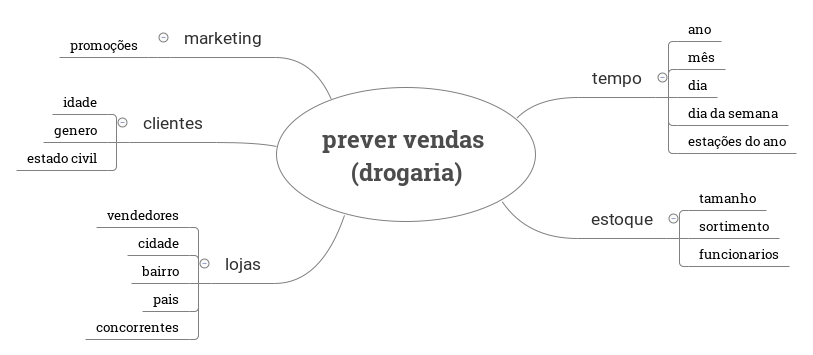

In [164]:
Image('../img/sales_forecast.png')

* **Tempo**
1. lojas vendem 10% mais durante os anos.
2. lojas vendem 30% a mais no mês de dezembro.
3. lojas vendem 20% a menos na 2a quinzena do mês
4. lojas vendem 20% a menos nos finais de semana (sex, sab, dom).
5. lojas vendem 30% a mais no inverno (dez, jan, fev, mar)

* **Estoque**
1. lojas vendem 10% a mais com estoques com maior sortimento

* **Loja**
1. lojas vendem 10% a mais com o maior número de vendedores 
2. lojas vendem 20% a mais nas capitais
3. lojas vendem 20% a menos com concorrentes mais próximos

* **Marketing**
1. lojas com mais tempo em promoções vendem menos

## 2.2. Feature Creation

### 2.2.1. Date

In [165]:
# date -> year, month, weekofyear, daysofweek
df2['year'] = df2['date'].dt.year

df2['month'] = df2['date'].dt.month

df2['weekofyear'] = df2['date'].dt.isocalendar().week

df2['dayofweek'] = df2['date'].dt.dayofweek

df2['weekofyear'] = df2['weekofyear'].astype('int64')

### 2.2.2. Seasons

In [166]:
df2.loc[(df2['date'].dt.strftime('%m-%d') >= '03-21') & (df2['date'].dt.strftime('%m-%d') <= '06-20'), 'seasons'] = 'spring'

df2.loc[(df2['date'].dt.strftime('%m-%d') >= '06-21') & (df2['date'].dt.strftime('%m-%d') <= '09-20'), 'seasons'] = 'summer'

df2.loc[(df2['date'].dt.strftime('%m-%d') >= '09-21') & (df2['date'].dt.strftime('%m-%d') <= '12-20'), 'seasons'] = 'fall'

df2.fillna('winter', inplace=True)

### 2.2.3. Competition

In [167]:
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1 ), axis=1 )

df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) / 30).apply(lambda x: x.days).astype(int)

### 2.2.4. Promo Since

In [168]:
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

### 2.2.5. Map Store Type and Assorment

In [169]:
# store_type
state_holiday_map = {'a': 'public_holiday', 'b': 'easter_holiday', 'c': 'christmas', '0': 'regular_day'}
df2['state_holiday'] = df2['state_holiday'].map(state_holiday_map)

In [170]:
# assortment
assortment_map = {'a': 'basic', 'b': 'extra', 'c': 'extended'}
df2['assortment'] = df2['assortment'].map(assortment_map)

# 3.0. Data Filtering

In [171]:
df3 = df2.copy()

## 3.1. Filter Rows

In [172]:
df3 = df3.loc[(df3['open'] != 0) & (df3['sales'] != 0) , :]

## 3.2. Filter Columns

In [173]:
cols_drop = ['promo_interval', 'open', 'month_map', 'customers', 'competition_since', 'promo_since']

df3 = df3.drop(cols_drop, axis=1)

# 4.0. EDA

In [174]:
df4 = df3.copy()

## 4.1. Univariate Analysis

In [175]:
# report = profile = ProfileReport(df4, title="Pandas Profiling Report")
# profile.to_file("../reports/output_v2.html")

## 4.2. Business Hypothesis Analysis

# 5.0. Data Preparation

In [176]:
df5 = df4.copy()

## 5.1. Standardization

## 5.2. Rescale

## 5.3. Encoder



In [177]:
le = pp.LabelEncoder()

df5['store_type'] = le.fit_transform( df5[['store_type']].values.ravel() )
df5['assortment'] = le.fit_transform( df5[['assortment']].values.ravel() )
df5['state_holiday'] = le.fit_transform( df5[['state_holiday']].values.ravel() )
df5['seasons'] = le.fit_transform( df5[['seasons']].values.ravel() )

# 6.0. Feature Selection

In [178]:
df6 = df5.copy()

## 6.1. Splitting data into training and test datasets

In [179]:
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=6*7)

Timestamp('2015-06-19 00:00:00')

In [180]:
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

# 7.0. Model Training

In [181]:
x_train = X_train.drop( ['date', 'sales'], axis=1 )
x_test = X_test.drop( ['date', 'sales'], axis=1 )

x_training = X_train.copy()

## 7.1. Average Model

In [182]:
# model definition
model_avg = DummyRegressor()

# fit
model_avg.fit(x_train, y_train)

# predictions
yhat_baseline = model_avg.predict(x_test)

# perfomance
result_baseline = ml_error('DummyRegressor', y_test, yhat_baseline)
result_baseline

,Model,MAE,MAPE,RMSE
0,DummyRegressor,2242.17,0.38,3044.29


In [183]:
result_baseline_cv = cross_validation(x_training, 5, 'DummyRegressor', model_avg)
result_baseline_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,DummyRegressor,2363.341 +/- 312.548,0.366 +/- 0.014,3245.574 +/- 486.305


## 7.2. Linear Regression Model

In [185]:
# model definition
model_lr = lm.LinearRegression()

# fit
model_lr.fit(x_train, y_train)

# predictions
yhat_lr = model_lr.predict(x_test)

# perfomance
result_lr = ml_error('LinearRegression', y_test, yhat_lr)
result_lr

,Model,MAE,MAPE,RMSE
0,LinearRegression,1970.41,0.33,2683.14


In [186]:
result_lr_cv = cross_validation(x_training, 5, 'LinearRegression', model_lr)
result_lr_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,LinearRegression,2092.583 +/- 261.473,0.316 +/- 0.008,2918.075 +/- 419.21


## 7.3. Linear Regression - Lasso

In [187]:
# model definition
model_lrr = lm.Lasso()

# fit
model_lrr.fit(x_train, y_train)

# predictions
yhat_lrr = model_lr.predict(x_test)

# perfomance
result_lrr = ml_error('Lasso', y_test, yhat_lrr)
result_lrr

CPU times: user 4min 9s, sys: 47.1 s, total: 4min 56s
Wall time: 1min 28s


/home/cid/.pyenv/versions/3.8.0/envs/local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 175774068958.12793, tolerance: 775042204.897893
  model = cd_fast.enet_coordinate_descent(


,Model,MAE,MAPE,RMSE
0,Lasso,1966.37,0.33,2682.30


In [188]:
result_lrr_cv = cross_validation(x_training, 5, 'LinearRegression - Lasso', model_lrr)
result_lrr_cv

/home/cid/.pyenv/versions/3.8.0/envs/local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 169470738689.62793, tolerance: 632497004.8464789
  model = cd_fast.enet_coordinate_descent(
/home/cid/.pyenv/versions/3.8.0/envs/local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 156687657742.2959, tolerance: 664242152.574351
  model = cd_fast.enet_coordinate_descent(
/home/cid/.pyenv/versions/3.8.0/envs/local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 132300726287.08203, tolerance: 695985381.445666
  model = cd_fast.enet_coordinate_descent(
/home/cid/.pyenv/versions

,Model Name,MAE CV,MAPE CV,RMSE CV
0,LinearRegression - Lasso,2092.387 +/- 261.522,0.316 +/- 0.008,2918.551 +/- 418.424


## 7.4. Random Forest Regressor

In [189]:
%%time
# model definition
model_rf = en.RandomForestRegressor()

# fit
model_rf.fit(x_train, y_train)

# predictions
yhat_rf = model_rf.predict(x_test)

# perfomance
result_rf = ml_error('RandomForestRegressor', y_test, yhat_rf)
result_rf

CPU times: user 10min 1s, sys: 7.81 s, total: 10min 9s
Wall time: 10min 46s


,Model,MAE,MAPE,RMSE
0,RandomForestRegressor,664.73,0.10,984.47


In [190]:
# result_rf_cv = cross_validation(x_training, 5, 'RandomForestRegressor', model_rf)
# result_rf_cv

## 7.5. XGBoost Regressor

In [191]:
%%time
# model definition
model_xgb = XGBRegressor(objective='reg:squarederror')

# fit
model_xgb.fit(x_train, y_train)

# predictions
yhat_xgb = model_xgb.predict(x_test)

# perfomance
result_xgb = ml_error('XGBRegressor', y_test, yhat_xgb)
result_xgb

CPU times: user 1min 1s, sys: 1.62 s, total: 1min 2s
Wall time: 1min 13s


,Model,MAE,MAPE,RMSE
0,XGBRegressor,1731.44,0.28,2404.53


In [192]:
# result_xgb_cv = cross_validation(x_training, 5, 'XGBRegressor', model_xgb)
# result_xgb_cv

## 7.6. Results

### 7.6.1. Single Performance

In [193]:
result = pd.concat([result_baseline, result_lr, result_lrr, result_rf, result_xgb])
result

,Model,MAE,MAPE,RMSE
0,DummyRegressor,2242.17,0.38,3044.29
0,LinearRegression,1970.41,0.33,2683.14
0,Lasso,1966.37,0.33,2682.30
0,RandomForestRegressor,664.73,0.10,984.47
0,XGBRegressor,1731.44,0.28,2404.53


### 7.6.2. Real Performance - Cross Validation

In [194]:
# result_cv = pd.concat([result_baseline_cv, result_lr_cv, result_lrr_cv, result_rf_cv, result_xgb_cv])
# result_cv

# 8.0. Hyperparameter Fine Tuning

# 9.0. Model Perfomance to Business 

# 10.0. Deploy to Product